<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/iamtomato761/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

file 8

# Part 0: Enabling GPU Acceleration & Introduction to Machine Learning

In [17]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1) Install Required Libraries


In [18]:
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch

## 2) Load and Stretch the RGB FITS Image

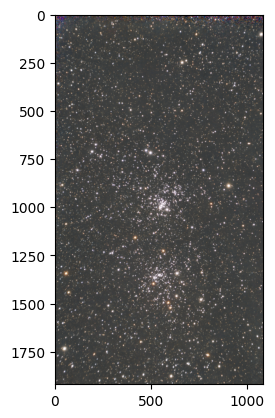

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

# Replace this URL with the raw URL of your FITS file on GitHub in https://github.com/ubsuny/PHY386/tree/main/data
# Check https://github.com/ubsuny/PHY386/blob/main/2025/HW/HW5-assignment.csv for the fits file assigned to you
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/8.fits"


# Fetch the FITS file from the GitHub repository
response = requests.get(fits_url)
response.raise_for_status()  # Check for request errors

# Load the FITS file into an HDUList using BytesIO
hdul = fits.open(BytesIO(response.content))

# Assume the first extension contains an RGB image in (3, Height, Width) format
rgb_data = np.transpose(hdul[0].data, (1, 2, 0))  # Shape should be (3, Height, Width)
hdul.close() #

# Display the image
fig = plt.figure()
plt.imshow(apply_stretch(rgb_data))

## 3) Count Stars Using Astropy

### Extract RGB files

In [20]:
# Extract RGB channels
r_channel = rgb_data[:, :, 0]
g_channel = rgb_data[:, :, 1]
b_channel = rgb_data[:, :, 2]

### Similar numb detected stars in each channel

In [21]:
# Calculate the mean of the RGB channels for detection
avg_channel = np.mean(rgb_data, axis=2)

# Function to detect stars
def detect_stars(image_data, fwhm=3.0, threshold_sigma=15.0):
    mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)
    finder = DAOStarFinder(fwhm=fwhm, threshold=threshold_sigma * std)
    return finder(image_data - median)

# Detect stars using the average channel
sources = detect_stars(avg_channel)
print(f"Number of detected stars (based on average): {len(sources)}")

Number of detected stars (based on average): 5016


### Plot

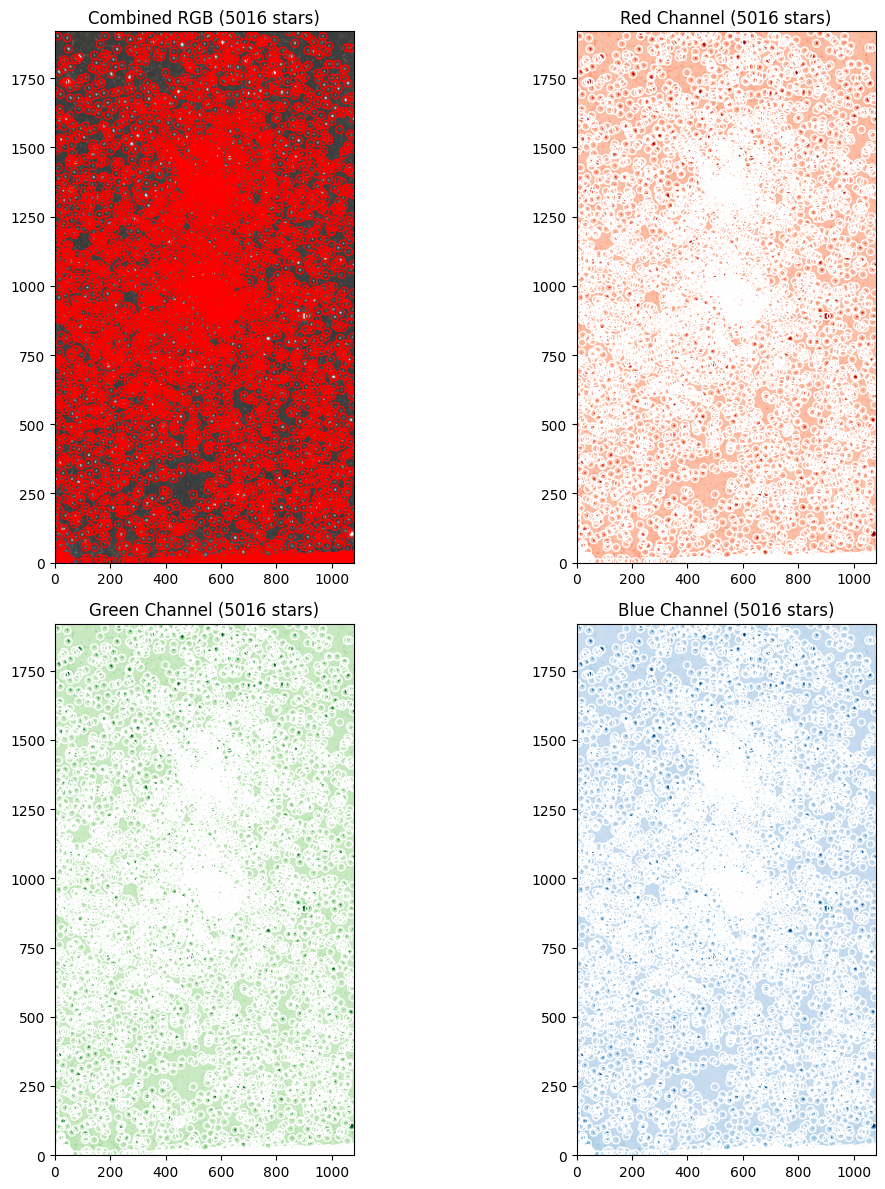

In [22]:
# Now, let's plot the combined and individual channels with the *same* detected stars
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. Combined RGB image with detected stars
axes[0, 0].imshow(apply_stretch(rgb_data), origin='lower')
axes[0, 0].scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='red', facecolors='none')
axes[0, 0].set_title(f'Combined RGB ({len(sources)} stars)')

# 2. Red channel with detected stars
axes[0, 1].imshow(apply_stretch(np.expand_dims(r_channel, axis=2)), cmap='Reds', origin='lower')
axes[0, 1].scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='white', facecolors='none')
axes[0, 1].set_title(f'Red Channel ({len(sources)} stars)')

# 3. Green channel with detected stars
axes[1, 0].imshow(apply_stretch(np.expand_dims(g_channel, axis=2)), cmap='Greens', origin='lower')
axes[1, 0].scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='white', facecolors='none')
axes[1, 0].set_title(f'Green Channel ({len(sources)} stars)')

# 4. Blue channel with detected stars
axes[1, 1].imshow(apply_stretch(np.expand_dims(b_channel, axis=2)), cmap='Blues', origin='lower')
axes[1, 1].scatter(sources['xcentroid'], sources['ycentroid'], s=30, edgecolor='white', facecolors='none')
axes[1, 1].set_title(f'Blue Channel ({len(sources)} stars)')

plt.tight_layout()
plt.show()

# Step 3: Feature Extraction

In [23]:
# Extract flux values for each detected star in each channel
r_flux = np.array([r_channel[int(y), int(x)] for x, y in zip(sources['xcentroid'], sources['ycentroid'])])
g_flux = np.array([g_channel[int(y), int(x)] for x, y in zip(sources['xcentroid'], sources['ycentroid'])])
b_flux = np.array([b_channel[int(y), int(x)] for x, y in zip(sources['xcentroid'], sources['ycentroid'])])

# Calculate color ratios
rg_ratio = r_flux / g_flux
bg_ratio = b_flux / g_flux

# Normalize the flux values for each channel
def normalize_flux(flux):
    return (flux - np.min(flux)) / (np.max(flux) - np.min(flux))

r_flux_norm = normalize_flux(r_flux)
g_flux_norm = normalize_flux(g_flux)
b_flux_norm = normalize_flux(b_flux)

# Print the color ratios (for the first 5 stars as an example)
print("Color Ratios (R/G for first 5 stars):", rg_ratio[:5])
print("Color Ratios (B/G for first 5 stars):", bg_ratio[:5])

# Print the normalized flux ratios (for the first 5 stars as an example)
print("Normalized Red Flux (first 5 stars):", r_flux_norm[:5])
print("Normalized Green Flux (first 5 stars):", g_flux_norm[:5])
print("Normalized Blue Flux (first 5 stars):", b_flux_norm[:5])

# Generate the new 'features' variable
# We'll combine the normalized R/G ratio, normalized B/G ratio, and the normalized size proxy
size = sources['sharpness']
size_norm = normalize_flux(size) # Applying the same normalization

features = np.vstack([rg_ratio, bg_ratio, size_norm]).T
print("Shape of the new 'features' array:", features.shape)
print("First 5 rows of the new 'features' array:\n", features[:5])

Color Ratios (R/G for first 5 stars): [1.06458333 0.89463602 1.85163205 0.91764706 1.04480652]
Color Ratios (B/G for first 5 stars): [1.06041667 1.07088123 1.16320475 1.04901961 0.9287169 ]
Normalized Red Flux (first 5 stars): [0.00319697 0.00237914 0.0052973  0.00239772 0.00323414]
Normalized Green Flux (first 5 stars): [0.00323173 0.00403488 0.00049719 0.00380541 0.00344208]
Normalized Blue Flux (first 5 stars): [0.00421459 0.00513481 0.00206129 0.00469311 0.00323916]
Shape of the new 'features' array: (5016, 3)
First 5 rows of the new 'features' array:
 [[1.06458333 1.06041667 0.37014544]
 [0.89463602 1.07088123 0.78065887]
 [1.85163205 1.16320475 0.48463382]
 [0.91764706 1.04901961 0.66068235]
 [1.04480652 0.9287169  0.29113479]]


# Step 4: Autoencoder for Feature Compression

In [24]:
# Define an autoencoder model
input_layer = Input(shape=(3,))  # Input shape is now 3 (R/G, B/G, size_norm)
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(2, activation='relu')(encoded)  # Bottleneck layer with 2 neurons

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(3, activation='sigmoid')(decoded) # Output shape is now 3 (to reconstruct the input features)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(features, features, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1337
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0130
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0099
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0087
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0085
Epoch 8/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080
Epoch 9/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 10/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074
Epoch 11/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075
Epoch 12/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076
Epoch 13/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0083
Epoch 14/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072
Epoch 15/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

# Step 5: Clustering with KMeans

In [25]:
encoder = Model(input_layer, encoded)  # Create a separate encoder model
encoded_features = encoder.predict(features)  # Get the compressed features

num_clusters = 4  # You can experiment with different numbers of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10) # Added n_init for stability
predicted_labels = kmeans.fit_predict(encoded_features)

print("Predicted cluster labels for the first 10 stars:", predicted_labels[:10])
print("Shape of the predicted labels:", predicted_labels.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predicted cluster labels for the first 10 stars: [0 0 3 0 0 2 1 0 0 0]
Shape of the predicted labels: (5016,)


# Step 6a: Generating Synthetic Star Data

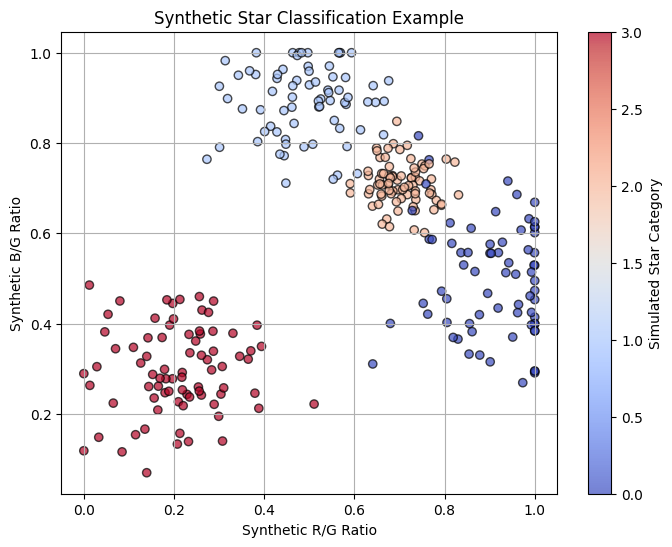

In [16]:
import random

def generate_synthetic_stars(num_stars=300):
    """Generates synthetic star data with predefined color and brightness properties."""
    categories = {
        0: {'rg': 0.9, 'bg': 0.5, 'scatter': 0.1},  # Red stars
        1: {'rg': 0.5, 'bg': 0.9, 'scatter': 0.1},  # Blue stars
        2: {'rg': 0.7, 'bg': 0.7, 'scatter': 0.05}, # White stars
        3: {'rg': 0.2, 'bg': 0.3, 'scatter': 0.1},  # Dim stars
    }

    stars = []
    labels = []

    for _ in range(num_stars):
        category = random.choice(list(categories.keys()))
        base = categories[category]
        rg = max(0, min(1, np.random.normal(base['rg'], base['scatter'])))
        bg = max(0, min(1, np.random.normal(base['bg'], base['scatter'])))
        stars.append([rg, bg])
        labels.append(category)

    return np.array(stars), np.array(labels)

# Generate and plot synthetic stars
synthetic_stars, synthetic_labels = generate_synthetic_stars()
plt.figure(figsize=(8,6))
plt.scatter(synthetic_stars[:,0], synthetic_stars[:,1], c=synthetic_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Synthetic R/G Ratio')
plt.ylabel('Synthetic B/G Ratio')
plt.colorbar(label='Simulated Star Category')
plt.title('Synthetic Star Classification Example')
plt.grid(True)
plt.show()

# Step 6b: Visualizing real data

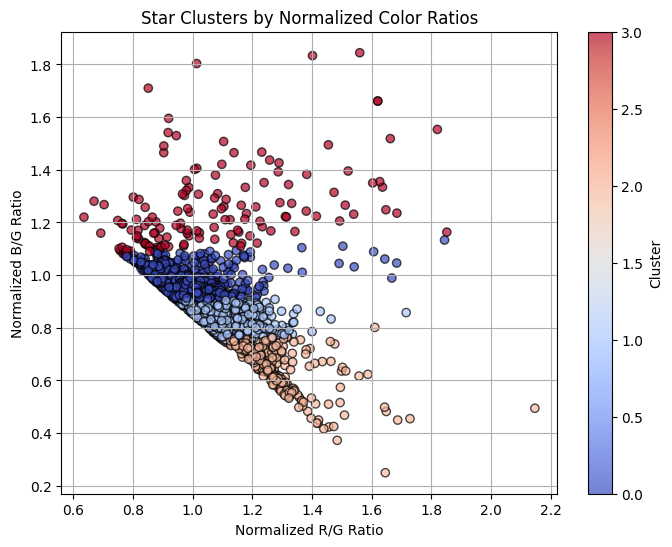

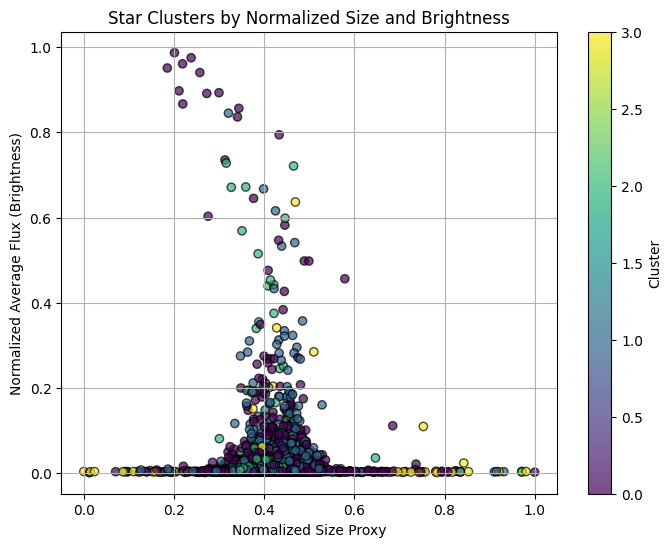

In [35]:
# Plot 1: Normalized R/G Ratio vs. Normalized B/G Ratio
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=predicted_labels, cmap='coolwarm', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized R/G Ratio')
plt.ylabel('Normalized B/G Ratio')
plt.colorbar(label='Cluster')
plt.title('Star Clusters by Normalized Color Ratios')
plt.grid(True)
plt.show()

# Calculate average normalized flux for brightness (optional)
avg_norm_flux = np.mean([r_flux_norm, g_flux_norm, b_flux_norm], axis=0)

# Plot 2: Normalized Size vs. Normalized Brightness (using average normalized flux)
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 2], avg_norm_flux, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Size Proxy')
plt.ylabel('Normalized Average Flux (Brightness)')
plt.colorbar(label='Cluster')
plt.title('Star Clusters by Normalized Size and Brightness')
plt.grid(True)
plt.show()

## 2nd plot flipped to fit desired axes

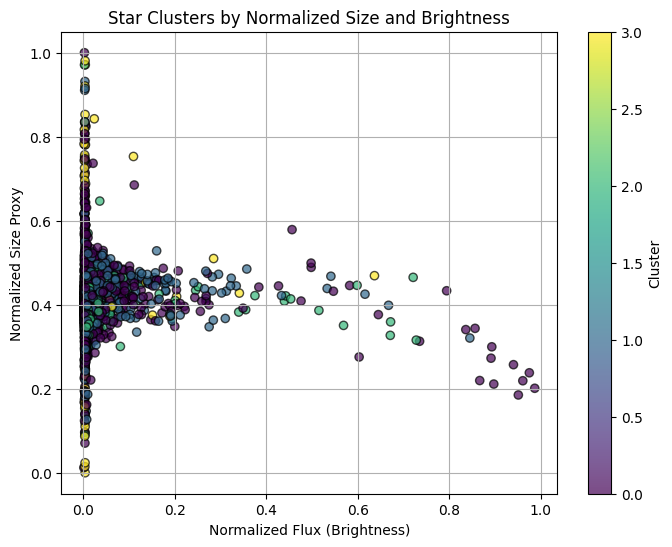

In [33]:
plt.figure(figsize=(8, 6))
# Calculate average normalized flux for brightness
# and assign it to flux_norm
flux_norm = np.mean([r_flux_norm, g_flux_norm, b_flux_norm], axis=0)
plt.scatter(flux_norm, size_norm, c=predicted_labels, cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized Flux (Brightness)')
plt.ylabel('Normalized Size Proxy')
plt.colorbar(label='Cluster')
plt.title('Star Clusters by Normalized Size and Brightness')
plt.grid(True)
plt.show()

Step 7: Refining the Clustering

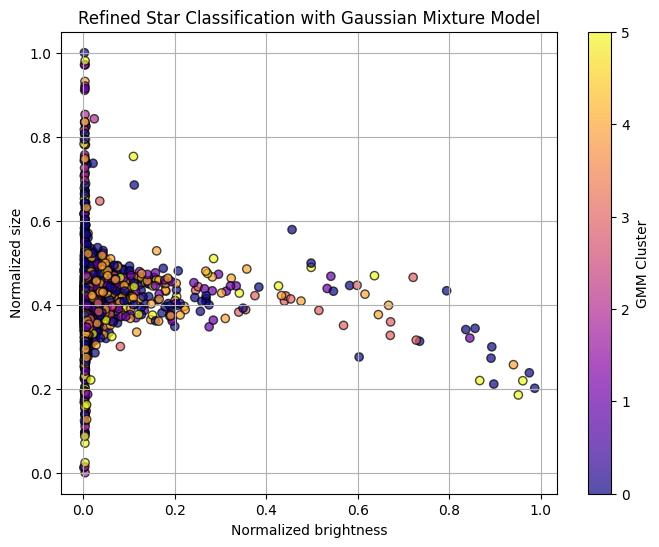

In [36]:
from sklearn.mixture import GaussianMixture

# Try different numbers of clusters
num_clusters_gmm = 6
gmm = GaussianMixture(n_components=num_clusters_gmm, random_state=42)
predicted_labels_gmm = gmm.fit_predict(encoded_features)

plt.figure(figsize=(8,6))
plt.scatter(flux_norm, size_norm, c=predicted_labels_gmm, cmap='plasma', alpha=0.7, edgecolors='k')
plt.xlabel('Normalized brightness')
plt.ylabel('Normalized size')
plt.colorbar(label='GMM Cluster')
plt.title('Refined Star Classification with Gaussian Mixture Model')
plt.grid(True)
plt.show()

The colors seems less seperated, so the boundaries of clusters by brightness and size are not clearly defined.